# Multiclass image segmentation

__Load Libraries__

In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
from glob import glob
import cv2
import numpy as np
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from PIL import Image
from osgeo import gdal

## Set Path

In [27]:
dir = os.getcwd()
parent_dir = os.path.dirname(dir)

PATH = parent_dir + '/data/Sentinel'                             
PATH_IMAGES = PATH + '/images/'
PATH_MASKS = PATH + '/masks/'
PATH_PREDICTIONS = PATH + '/predictions/' 

import sys
sys.path.append(parent_dir)

## Import custom functions

In [4]:
#from scripts
from library.data_preprocessing_multiclass import load_data, tf_dataset_geo, read_image, read_select_geo_channel, read_original_size
from library.data_augmentation import augment_data, load_augmented_x_train_y_train, create_dir
from library.models import unet_large, mobile_netv2
from library.metrics import *
from library.visualisation_multiclass import *

# Define Hyperparemeters

In a first step, we can define some hyperparameters:
- **Shape**:  The shape of the images we feed into the model
- **Num_classes**: How many classes do we try to predict?
- **BATCH**: Batch Size
- **Epochs**: For how many epochs do we train our model
- **learning_rate**: reasonable values: 1e-4 for mobile_netv2, 1e-5 for Unet_large

In [5]:
#Define amount of classes the model should predict, the height (H) and width (W) of the image.
num_classes = 3
H=256 
W=256
shape = (W, H, num_classes)
chanels = [4,3,2]

#Define the batch size, for how many epochs we want to train our model and the learning_rate.
BATCH = 4
epochs = 50
learning_rate = 1e-4

## Load Data
Now, we can load the data and split them into train, validation and testing set. Per default, the train / val / test-split is 80% / 10% /10%. If required, this can be adapted by changing 'split = 0.1' to the desired degree.

In [6]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path_images = PATH_IMAGES, path_masks = PATH_MASKS, split = 0.1)
print(f"Dataset: Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

Dataset: Train: 8 - Valid: 1 - Test: 1


## Create Datasets

As we have now the to correct splits and all data as we need, we can create the train_dataset, valid_dataset and test_dataset. To do so, use the function tf_dataset. This function loads the images and masks, resizes them to the defined size, normalizes images and performs one-hot encoding on the masks.

Check the **data_preprocessing_multiclasss.py** script to check the code in detail.

In [7]:
train_dataset = tf_dataset_geo(train_x, train_y, chanels, batch=BATCH, width=W, height=H)
valid_dataset = tf_dataset_geo(valid_x, valid_y, chanels, batch=BATCH, width=W, height=H)
test_dataset = tf_dataset_geo(test_x, test_y, chanels, batch=BATCH, width=W, height=H)

## Model
Let's now define the model and metrics we are using to evaluate the performance of the models.

### Metrics
As metric to evaluate the performance of the model, the dice coef was used. The Dice Coefficient is 2 * the Area of Overlap divided by the total number of pixels in both images. The dice coef allows thus to gauge the similarity of two samples.

While the dice_coef allows to monitor the overall performance, three seperate metrics were created to analyse, the performance for each class:


- **dice_coef_c1**: Not segment 1 nor segement 2
- **dice_coef_c2**: Segment 1
- **dice_coef_c3**: Segment 2

This would need to be increased according to the amount of classes but maybe start with 3 classes is a good starting point.

In [8]:
METRICS= [dice_coef, dice_coef_c1, dice_coef_c2, dice_coef_c3]

### Define Model
Now we define the model. Two diffrent Unet models are available for this task. As the name already suggests, the mobilenet model uses a pretrained mobilenet (trained on imagenet) as a decoder. The second model is a relatively large unet which was built from scratch. For the given task, of segmenting three diffrent classes, the performance of both models were quite similar.

- Check the sript models.py for exact model architecture.

In [9]:
""" Model 1"""
#model = mobile_netv2(shape, num_classes)

' Model 1'

In [12]:
""" Model 2"""
model = unet_large(shape, num_classes)

# also any othet model can be used here... and would be a good practice if any other model is used to add it to the library/models.py file

###  Compile Model
To train a model with fit(), we need to specify a loss function, an optimizer, and optionally, some metrics to monitor. We use the dice_loss as a loss function and the Adam algorithm as an optimizer. The learning_rate and the metrics were already defined.

In [13]:
model.compile(loss=dice_loss, optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=METRICS)

In [14]:
#summaries the model
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_image[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

### Callbacks
Callbacks are objects that can perform tasks at various stages of the training process. The following call-backs are used during the training process:

- **ModelCheckpoint**: Saves the best model
- **ReduceLROnPlateau**: Reduce learning rate when a metric has stopped improving.
- **EarlyStopping**: Stop training when a monitored metric has stopped improving.

In [15]:
callbacks = [
        ModelCheckpoint(parent_dir + '/models/multiclass.h5',  verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
        EarlyStopping(monitor="val_loss", patience=10, verbose=1)
    ]

## Train the Model
We can now start with the training process of the model. As a last step we define the train_steps and valid_steps and then pass all the needed arguments into the model.fit() function.

In [16]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

In [17]:
history = model.fit(train_dataset,
        steps_per_epoch=train_steps,
        validation_data=valid_dataset,
        validation_steps=valid_steps,
        epochs=epochs,
        callbacks=callbacks
    )

Epoch 1/50
2/2 [==============================] - ETA: 0s - loss: 0.9717 - dice_coef: 0.0283 - dice_coef_c1: 0.0850 - dice_coef_c2: 0.0000e+00 - dice_coef_c3: 0.0000e+00
Epoch 00001: val_loss improved from inf to 0.97161, saving model to /Users/leticiafernandezmoguel/Desktop/DS_projects/LandPRO_LFM/models/multiclass.h5
2/2 [==============================] - 3s 2s/step - loss: 0.9717 - dice_coef: 0.0283 - dice_coef_c1: 0.0850 - dice_coef_c2: 0.0000e+00 - dice_coef_c3: 0.0000e+00 - val_loss: 0.9716 - val_dice_coef: 0.0284 - val_dice_coef_c1: 0.0852 - val_dice_coef_c2: 0.0000e+00 - val_dice_coef_c3: 0.0000e+00
Epoch 2/50
2/2 [==============================] - ETA: 0s - loss: 0.9716 - dice_coef: 0.0284 - dice_coef_c1: 0.0852 - dice_coef_c2: 0.0000e+00 - dice_coef_c3: 0.0000e+00
Epoch 00002: val_loss improved from 0.97161 to 0.97154, saving model to /Users/leticiafernandezmoguel/Desktop/DS_projects/LandPRO_LFM/models/multiclass.h5
2/2 [==============================] - 2s 1s/step - loss: 0.

## Saving model and training history

The best model is already saved. If we want to track and save the training history (perfromance after each epoch) we can do that by applying the following code.

In [18]:
SAVEFILE_NAME = 'multiclass'
SAVE_FORMAT = 'h5'
path_model = os.path.join(parent_dir + '/models/', SAVEFILE_NAME)          

Full_history = {}
for x in history.history:
    Full_history[x]  = history.history[x] 

np.save(path_model+'_training_history.npy', Full_history)

__Load previous model and history__

If we want to continue training of a model which was already trained, use the following functions to reload the saved model:

In [ ]:
# # load history
# Full_history = np.load(path_model+'_training_history.npy',allow_pickle='TRUE').item()
# print(Full_history.keys()) #prints keys
# # Load model
# model =  tf.keras.models.load_model(path_model+ '.' + SAVE_FORMAT, custom_objects={'dice_loss': dice_loss, 'dice_coef': dice_coef,
#                                                                                    'dice_coef_c1': dice_coef_c1, 'dice_coef_c2':dice_coef_c2,
#                                                                                    'dice_coef_c3': dice_coef_c3}, compile=True)

## Plot training performance metrics

The training process is completed so let's plot the training performance metrics to analyse, how they have changed from epoch to epoch.

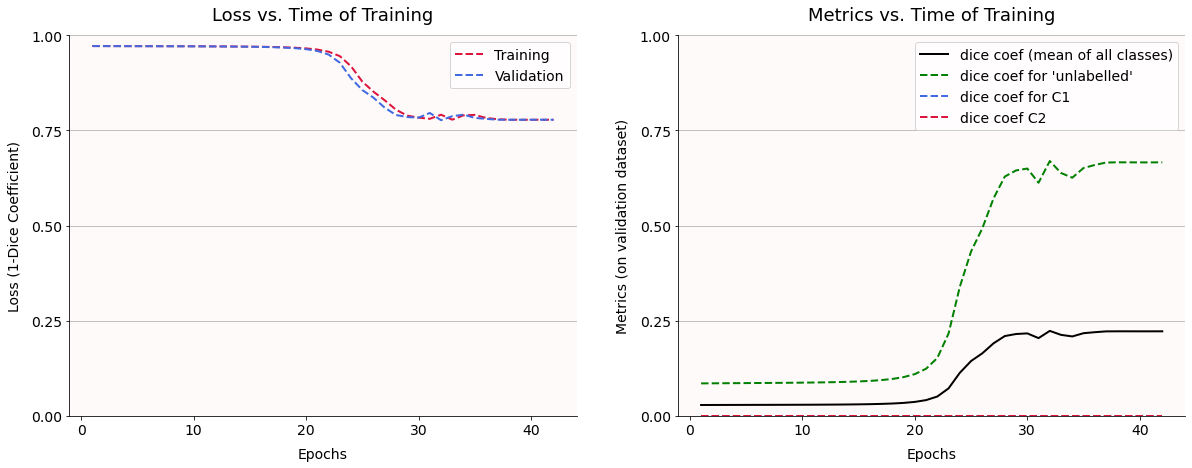

In [19]:
## Plot training history
training_loss = Full_history['loss']
validation_loss = Full_history['val_loss']
training_dice_coef = Full_history['dice_coef']
training_dice_coef_c1 = Full_history['dice_coef_c1']
training_dice_coef_c2 = Full_history['dice_coef_c2']
training_dice_coef_c3 = Full_history['dice_coef_c3']

## Plot validation history

validation_dice_coef = Full_history['val_dice_coef']
validation_dice_coef_c1 = Full_history['val_dice_coef_c1']
validation_dice_coef_c2 = Full_history['val_dice_coef_c2']
validation_dice_coef_c3 = Full_history['val_dice_coef_c3']


epoch_count = range(1, len(training_loss) + 1)
fig, axs = plt.subplots(1, 2, figsize = (20, 7))


# first supbplot for losses
axs[0].plot(epoch_count, training_loss, color = 'crimson', linestyle ='--', linewidth = 2)
axs[0].plot(epoch_count, validation_loss, color = 'royalblue', linestyle ='--', linewidth = 2)

axs[0].set_title('Loss vs. Time of Training', fontsize=18, pad=15)
axs[0].set_ylabel('Loss (1-Dice Coefficient)', fontsize=14, labelpad=10)
axs[0].set_xlabel('Epochs', fontsize=14, labelpad=10)
axs[0].legend(['Training', 'Validation'], fontsize=14)

axs[0].set_yticks([0, 0.25, 0.5, 0.75, 1])
axs[0].set_ylim((0,1))
axs[0].xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
axs[0].tick_params(labelsize=14)
axs[0].grid(which='both', axis='y', linewidth =1, color = 'silver')
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].patch.set_facecolor('snow')


#validation loss

axs[1].plot(epoch_count, validation_dice_coef, color = 'black', linestyle ='-', linewidth = 2)
axs[1].plot(epoch_count, validation_dice_coef_c1, color = 'green', linestyle ='--', linewidth = 2)
axs[1].plot(epoch_count, validation_dice_coef_c2, color = 'royalblue', linestyle ='--', linewidth = 2)
axs[1].plot(epoch_count, validation_dice_coef_c3,  color = 'crimson', linestyle ='--', linewidth = 2)

axs[1].set_title('Metrics vs. Time of Training', fontsize=18, pad=15)
axs[1].set_ylabel('Metrics (on validation dataset)',  fontsize=14, labelpad=10)
axs[1].set_xlabel('Epochs', fontsize=14, labelpad=10)
axs[1].legend([ "dice coef (mean of all classes)", "dice coef for 'unlabelled'", "dice coef for C1", "dice coef C2"], fontsize=14)

axs[1].set_yticks([0, 0.25, 0.5, 0.75, 1])
axs[1].set_ylim((0,1))
axs[1].xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
axs[1].tick_params(labelsize=14)
axs[1].grid(which='both', axis='y', linewidth =1, color = 'silver')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].patch.set_facecolor('snow')

None

## Evaluate on test data

Evaluate the models performance on the test_dataset:

In [43]:
results = model.evaluate(test_dataset, steps=valid_steps)

1/1 [==============================] - 0s 782us/step - loss: 0.7780 - dice_coef: 0.2220 - dice_coef_c1: 0.6661 - dice_coef_c2: 0.0000e+00 - dice_coef_c3: 0.0000e+00
